In [32]:
import os
from tqdm import tqdm

import pandas as pd
import numpy as np
import dask.dataframe as dd

import datashader
from datashader import transfer_functions as tf
from datashader.colors import Hot, viridis

import matplotlib.pyplot as plt
from auto_ts import auto_timeseries

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Combining Data Files based on category

In [9]:
BASE_DIR = 'C:/Users/20220678/Microsoft VS Code/JBG050-DC2-GRP21'
DATA_DIR = os.path.join(BASE_DIR, 'data')
crimes_outcomes_stopnsearch_dir = os.path.join(DATA_DIR, 'crimes_outcomes_stopnsearch')
curated_data_dir = os.path.join(DATA_DIR, 'curated_data')

if not os.path.exists(curated_data_dir):
    os.makedirs(curated_data_dir)

In [10]:
%%time

#* ====================================================================
#* === Data Aggregation and Curation ===
#* ====================================================================

stop_and_search_files, outcome_files, crime_files = [], [], []

# Collect all relevant CSV filenames
print("\nCurating all relevant CSV filenames...")
for root, dirs, files in tqdm(os.walk(crimes_outcomes_stopnsearch_dir)):
    for file in files:
        if file.endswith("stop-and-search.csv"):
            stop_and_search_files.append(os.path.join(root, file))
        elif file.endswith("outcomes.csv"):
            outcome_files.append(os.path.join(root, file))
        elif file.endswith("street.csv"):
            crime_files.append(os.path.join(root, file))
        else:
            print(f"Unknown file category: {file}")

# Print Statistics
print(f"\nNumber of Stop and Search files: {len(stop_and_search_files)}")
print(f"Number of Outcome files: {len(outcome_files)}")
print(f"Number of Crime files: {len(crime_files)}")

# Combine all files into one DataFrame
print("\nCombining files into single DataFrame(s) based on category...")

print("\nCombining Stop and Search files...")
stop_and_search_df = pd.concat((pd.read_csv(file) for file in tqdm(stop_and_search_files)), ignore_index=True)
stop_and_search_df.to_csv(os.path.join(curated_data_dir, 'stop_and_search.csv'), index=False)
stop_and_search_df.to_parquet(os.path.join(curated_data_dir, 'stop_and_search.parquet'), index=False)
print('Stop and Search DataFrame saved as CSV and Parquet files')
print("\nStop and Search DataFrame Info:")
print(stop_and_search_df.info())


print("\nCombining Outcome files...")
outcome_df = pd.concat((pd.read_csv(file) for file in tqdm(outcome_files)), ignore_index=True)
outcome_df.to_csv(os.path.join(curated_data_dir, 'outcome.csv'), index=False)
outcome_df.to_parquet(os.path.join(curated_data_dir, 'outcome.parquet'), index=False)
print('Outcome DataFrame saved as CSV and Parquet files')
print("\nOutcome DataFrame Info:")
print(outcome_df.info())


print("\nCombining Crime files...")
crime_df = pd.concat((pd.read_csv(file) for file in tqdm(crime_files)), ignore_index=True)
crime_df.to_csv(os.path.join(curated_data_dir, 'crime.csv'), index=False)
crime_df.to_parquet(os.path.join(curated_data_dir, 'crime.parquet'), index=False)
print('Crime DataFrame saved as CSV and Parquet files')
print("\nCrime DataFrame Info:")
print(crime_df.info())


Curating all relevant CSV filenames...


36it [00:00, 3683.34it/s]



Number of Stop and Search files: 35
Number of Outcome files: 35
Number of Crime files: 35

Combining files into single DataFrame(s) based on category...

Combining Stop and Search files...


  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:02<00:00, 13.10it/s]


Stop and Search DataFrame saved as CSV and Parquet files

Stop and Search DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517765 entries, 0 to 517764
Data columns (total 15 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Type                                      517765 non-null  object 
 1   Date                                      517765 non-null  object 
 2   Part of a policing operation              517765 non-null  bool   
 3   Policing operation                        0 non-null       float64
 4   Latitude                                  463734 non-null  float64
 5   Longitude                                 463734 non-null  float64
 6   Gender                                    511790 non-null  object 
 7   Age range                                 445853 non-null  object 
 8   Self-defined ethnicity                    511826 non-null  object 
 9   Of

100%|██████████| 35/35 [00:09<00:00,  3.56it/s]


Outcome DataFrame saved as CSV and Parquet files

Outcome DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556761 entries, 0 to 2556760
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Crime ID      object 
 1   Month         object 
 2   Reported by   object 
 3   Falls within  object 
 4   Longitude     float64
 5   Latitude      float64
 6   Location      object 
 7   LSOA code     object 
 8   LSOA name     object 
 9   Outcome type  object 
dtypes: float64(2), object(8)
memory usage: 195.1+ MB
None

Combining Crime files...


100%|██████████| 35/35 [00:12<00:00,  2.71it/s]


Crime DataFrame saved as CSV and Parquet files

Crime DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240987 entries, 0 to 3240986
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Crime ID               object 
 1   Month                  object 
 2   Reported by            object 
 3   Falls within           object 
 4   Longitude              float64
 5   Latitude               float64
 6   Location               object 
 7   LSOA code              object 
 8   LSOA name              object 
 9   Crime type             object 
 10  Last outcome category  object 
 11  Context                float64
dtypes: float64(3), object(9)
memory usage: 296.7+ MB
None
CPU times: total: 1min 34s
Wall time: 1min 37s


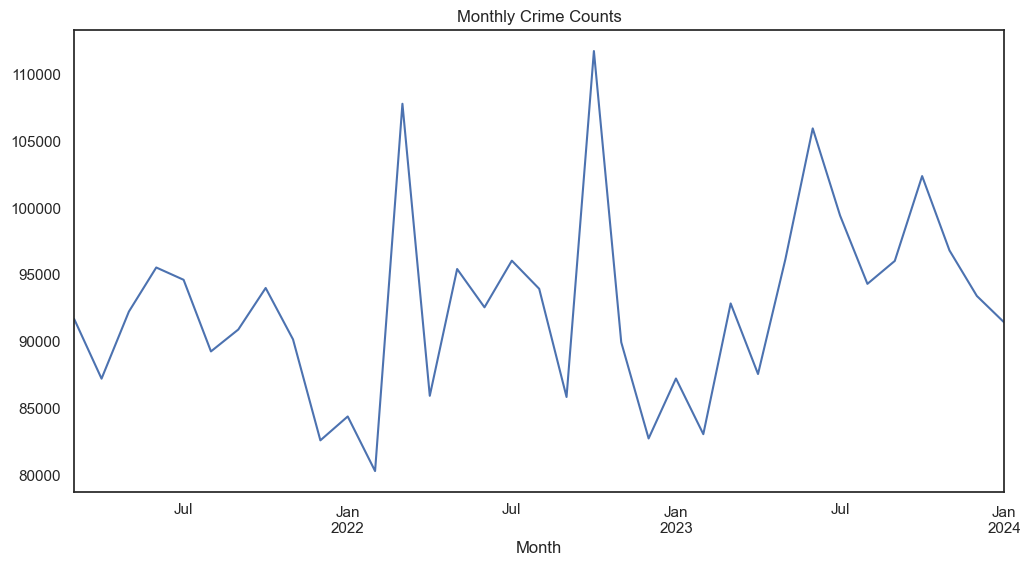

In [11]:
crime_df['Month'] = pd.to_datetime(crime_df['Month'], format='%Y-%m')

monthly_crimes = crime_df.groupby('Month').size()

plt.figure(figsize=(12, 6))
monthly_crimes.plot(title='Monthly Crime Counts')
plt.show()


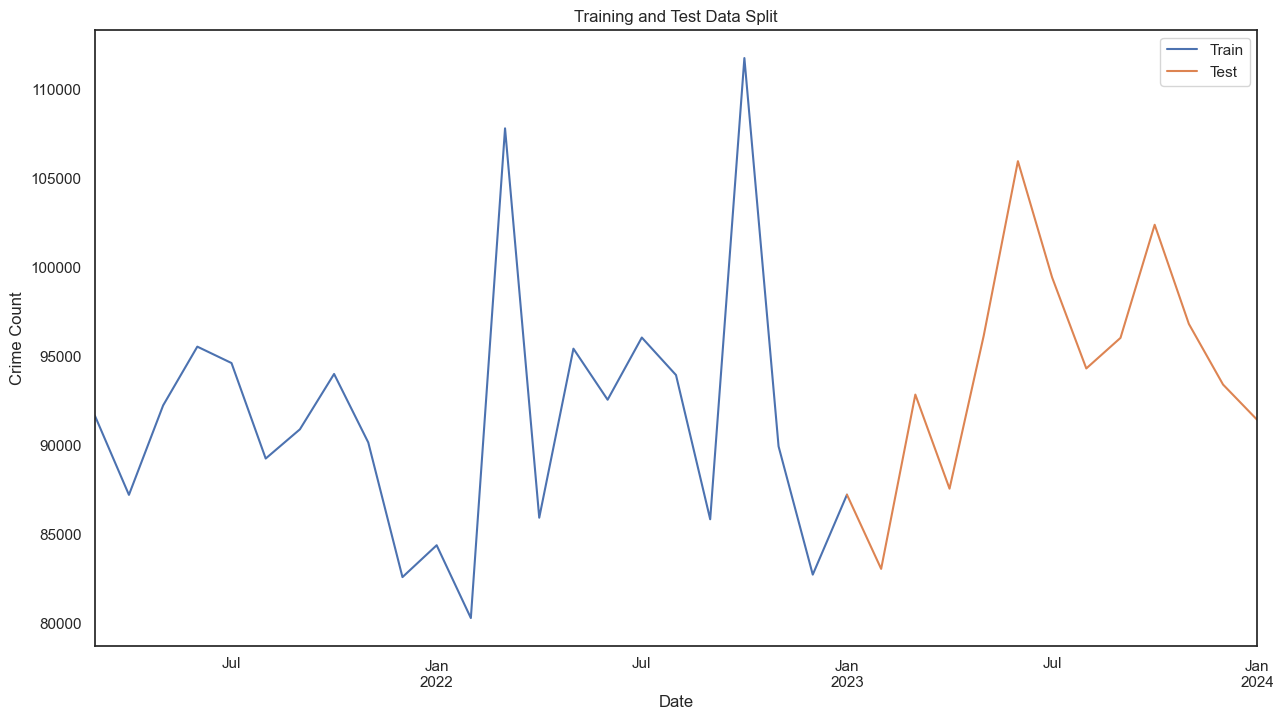

In [17]:
# Aggregate the data by each distinct month-year
monthly_crime_count = crime_df.groupby('Month').size().reset_index(name='CrimeCount')

train_df = monthly_crime_count.iloc[:-12]  # Training on the first 23 months
test_df = monthly_crime_count.iloc[-13:]   # Testing on the last 12 months

# Plot the split of data
plt.figure(figsize=(15, 8))
train_df.set_index('Month')['CrimeCount'].plot(label='Train')
test_df.set_index('Month')['CrimeCount'].plot(label='Test')
plt.title('Training and Test Data Split')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

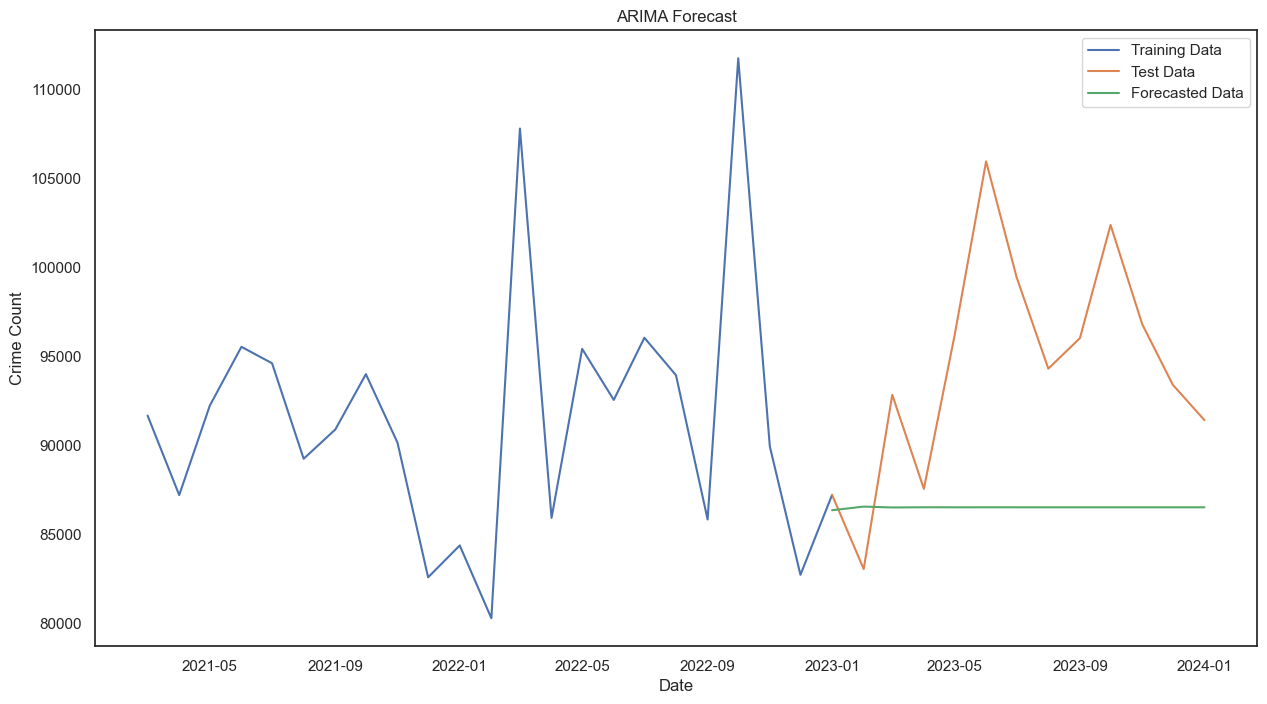

Mean Absolute Error: 8379.991094782708
Root Mean Square Error: 9888.586238143891


In [43]:
# That's a wrong approach probably but I am leaving it here in case we need it later on.

# Fit the ARIMA model
model = ARIMA(train_df['CrimeCount'], order=(1,1,1))  # example parameters
model_fit = model.fit()

forecast = model_fit.forecast(steps=13)
forecast_index = test_df['Month']

mae = mean_absolute_error(test_df['CrimeCount'], forecast)
rmse = math.sqrt(mean_squared_error(test_df['CrimeCount'], forecast))

plt.figure(figsize=(15, 8))
plt.plot(train_df['Month'], train_df['CrimeCount'], label='Training Data')
plt.plot(test_df['Month'], test_df['CrimeCount'], label='Test Data')
plt.plot(forecast_index, forecast, label='Forecasted Data')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

print("Mean Absolute Error:", mae)
print("Root Mean Square Error:", rmse)

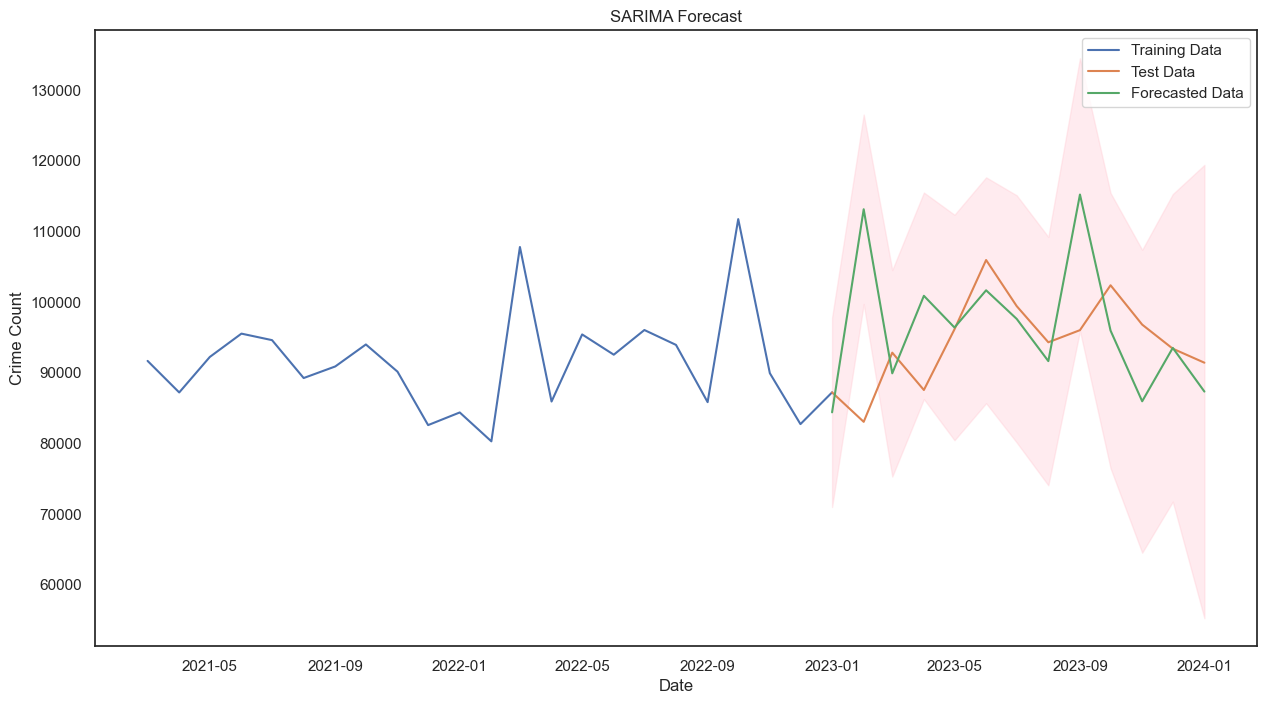

In [42]:
# Fit the SARIMA model
sarima_model = SARIMAX(train_df['CrimeCount'], 
                       order=(1, 1, 2), 
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()

# Forecasting
forecast = sarima_result.get_forecast(steps=13)
forecast_index = test_df['Month']
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# The data should not go below zero, that's why I applied a correction to the forecast mean (pls check if that's correct or at least valid)
forecast_mean_corrected = np.maximum(0, forecast_mean)

plt.figure(figsize=(15, 8))
plt.plot(train_df['Month'], train_df['CrimeCount'], label='Training Data')
plt.plot(test_df['Month'], test_df['CrimeCount'], label='Test Data')
plt.plot(forecast_index, forecast_mean_corrected, label='Forecasted Data')
plt.fill_between(forecast_index,
                 np.maximum(0, confidence_intervals.iloc[:, 0]),
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.show()
